In [38]:
%matplotlib inline
import cv2
import os
import matplotlib.pyplot as plt
from util.data_utils import get_horizontal_strip, visualize_formula, get_window

class CharacterSequenceEncoder(object):
    """ Encodes a sequence of characters to a sequence of indices. 
    
    Such indices serve as the target "label" for the character sequence.
    The index zero is reserved for unknown characters.
    """
    def __init__(self, character_mapping_file):
        self.mapping = {}
        with open(character_mapping_file) as fp:
            for idx, line in enumerate(fp):
                self.mapping[line.strip()] = idx
                
    def encode(self, sequence):
        """ Encodes a sequence of characters represented as a string.
        
        Characters that are not found in the mapping will be replaced with the
        PAD character.
        
        Args:
            sequence: a string of characters
            
        Returns:
            List of integers corresponding to the indices of the given characters.
        """
        return [self.mapping.get(char, 0) for char in sequence] + [self.mapping['STOP']]
    
def example_generator(filename, formula_file, limit=-1, imagedir="data/cropped_images"):
    with open('data/im2latex_formulas.lst') as fp:
        formulas = [l.strip() for l in fp]
    
    with open(filename) as fp:
        for n, line in enumerate(fp):
            if n == limit:
                return

            idx, img, _ = line.split()
            image_file = os.path.join(imagedir, "%s.png") % img
            formula = formulas[int(idx)]
            image = cv2.imread(image_file)
            if image is None:
                print "Image file does not exist:", image_file
                continue

            yield formula, cv2.imread(image_file), image_file

data/cropped_images/60ee748793.png


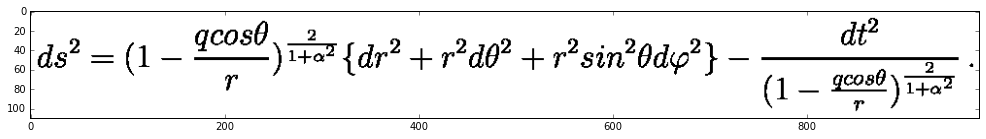

ds^{2} = (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}\lbrace dr^2+r^2d\theta^2+r^2sin^2\theta d\varphi^2\rbrace -{dt^2\over  (1 - {qcos\theta\over r})^{2\over 1 + \alpha^{2}}}\, .\label{eq:sps1}
data/cropped_images/66667cee5b.png


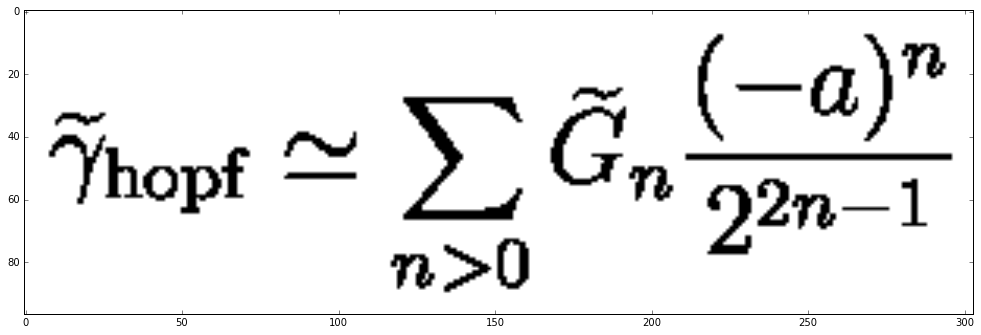

\widetilde\gamma_{\rm hopf}\simeq\sum_{n>0}\widetilde{G}_n{(-a)^n\over2^{2n-1}}\label{H4}
data/cropped_images/1cbb05a562.png


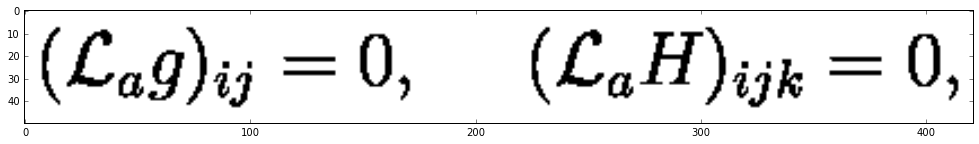

({\cal L}_a g)_{ij} = 0, \ \ \ \ ({\cal L}_a H)_{ijk} = 0 ,


In [39]:
# Generate a couple of examples as a sanity check.
it = example_generator('data/im2latex_train.lst', 'data/im2latex_formulas.lst', limit=3)
def show_and_tell(formula, image):
    plt.figure(figsize=(17,15))
    plt.imshow(image)
    plt.show()
    print formula    

for formula, image, image_filename in it:
    print image_filename
    show_and_tell(formula, image)

In [40]:
# Now let's actually create a nice training dataset.
# Not all of the images will fit in memory, but we want to group them by the size of the image. This will make
# mini-batches more efficient.
it = example_generator('data/im2latex_train.lst', 'data/im2latex_formulas.lst', limit=1000)

# Create tuples of (filename, formula_size)
examples = []
for formula, image, filename in it:
    size = image.shape[0:2]
    data = (formula, filename)
    examples.append((data, size))
    
h_buckets = [60, 100, 200, 350]
w_buckets = [400, 800, 1000, 1200, 1400]

buckets = {}
for h in h_buckets:
    for w in w_buckets:
        buckets[(h, w)] = []
        
def find_bucket(elem, buckets):
    for b in buckets:
        if b > elem:
            return b

# Each example falls into one of these exactly one h_bucket and one w_bucket.
for data, size in examples:
    hb = find_bucket(size[0], h_buckets)
    wb = find_bucket(size[1], w_buckets)
    if hb is None or wb is None:
        print "Couldn't find bucket for dims:", size
        continue

    buckets[(hb, wb)].append(data)

Image file does not exist: data/cropped_images/1f6cbf77e4.png
Image file does not exist: data/cropped_images/f0bf0dc25d.png
Couldn't find bucket for dims: (413, 450)
Couldn't find bucket for dims: (371, 621)
Couldn't find bucket for dims: (356, 733)


In [41]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from util.pad import pad_image
import tensorflow as tf

def _int64_feature(value):
    if not isinstance(value, list):
        value = [value]

    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


encoder = CharacterSequenceEncoder('character_mapping.txt')
writer = tf.python_io.TFRecordWriter(
        "im2latex_train.tfrecord")
for bucket in buckets:
    print "Processing bucket:", bucket
    print "Num images:", len(buckets[bucket])
    for data in buckets[bucket]:
        formula, filename = data
        im = cv2.imread(filename)
        binary_im = np.all(im == 0, 2).astype(np.uint8)
        padded, _ = pad_image(binary_im, [bucket], value=0)
        if padded is None:
            print "Error processing:", filename
            
        image_raw = padded.tostring()
        encoded_formula = encoder.encode(formula)
        example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(bucket[0]),
            'width': _int64_feature(bucket[1]),
            'label': _int64_feature(encoded_formula),
            'sequence_length': _int64_feature(len(encoded_formula)),
            'image_raw': _bytes_feature(image_raw)}))
        writer.write(example.SerializeToString())

writer.close()

Processing bucket: (200, 400)
Num images: 22
Processing bucket: (350, 800)
Num images: 3
Processing bucket: (60, 1200)
Num images: 7
Processing bucket: (200, 800)
Num images: 71
Processing bucket: (100, 1000)
Num images: 69
Processing bucket: (60, 400)
Num images: 145
Processing bucket: (350, 1000)
Num images: 1
Processing bucket: (200, 1400)
Num images: 3
Processing bucket: (60, 1000)
Num images: 30
Processing bucket: (200, 1200)
Num images: 23
Processing bucket: (100, 1400)
Num images: 3
Processing bucket: (200, 1000)
Num images: 30
Processing bucket: (350, 400)
Num images: 2
Processing bucket: (100, 1200)
Num images: 30
Processing bucket: (60, 800)
Num images: 145
Processing bucket: (100, 800)
Num images: 257
Processing bucket: (350, 1200)
Num images: 2
Processing bucket: (100, 400)
Num images: 151
Processing bucket: (350, 1400)
Num images: 0
Processing bucket: (60, 1400)
Num images: 1
